In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.DataFrame(pd.read_excel("IR00_3_11k News.xlsx"))
df.head()

,id,content,topic,url
0,1,به گزارش ایسنا، پس از استعفا علی نکویی رئیس شا...,sport,https://www.isna.ir/news/99010100077/حواشی-در-...
1,2,به گزارش ایسنا، امیر محسنی با بیان اینکه این ل...,sport,https://www.isna.ir/news/98122922468/ثبت-نام-ب...
2,3,آرش فرهادیان در گفت و گو با ایسنا، درباره آخری...,sport,https://www.isna.ir/news/99010200541/فرهادیان-...
3,4,به گزارش ایسنا، فدراسیون بین المللی شنا قانونی...,sport,https://www.isna.ir/news/99010200528/فناوری-وی...
4,5,به گزارش ایسنا، فدراسیون جهانی صعودهای ورزشی (...,sport,https://www.isna.ir/news/99010200510/تعویق-زما...


In [4]:
df = df.loc[:, ['id', 'topic']]
df.head()

,id,topic
0,1,sport
1,2,sport
2,3,sport
3,4,sport
4,5,sport


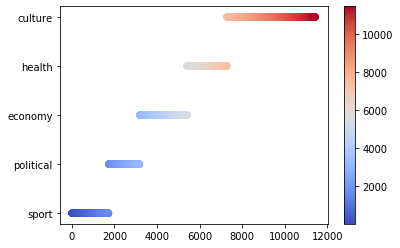

In [19]:
from matplotlib.cm import coolwarm
fig, ax = plt.subplots()

s = ax.scatter(df.id,df.topic, c=df.id , cmap=coolwarm)
plt.colorbar(s)

In [1]:
import pickle

In [2]:
training_data_11k = []
with open('training_data_50k.pkl' ,'rb')as f :
    training_data_11k = pickle.load(f)

In [3]:
# training_data_11k[0]

In [4]:
pip install -U gensim

Requirement already up-to-date: gensim in c:\users\asus\anaconda3\lib\site-packages (4.1.2)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import multiprocessing
from gensim.models import Word2Vec
import time
import numpy as np
from numpy.linalg import norm

In [6]:
cores = multiprocessing.cpu_count()
print('Number of cores in this device {}'.format(cores))

Number of cores in this device 8


In [7]:
docs_num = len(training_data_11k)
tokens_num = sum([len(x) for x in training_data_11k])
print('Number of all docs {}'.format(docs_num))
print('Number of all Tokens {}'.format(tokens_num))

Number of all docs 50061
Number of all Tokens 12325127


In [8]:
%%time
w2v_model = Word2Vec(min_count=1 , window=15 , vector_size=300 , alpha=0.03 , workers=cores-1)
w2v_model.build_vocab(training_data_11k)
w2v_model_vocab_size = len(w2v_model.wv)
print('Vocab size : ' , w2v_model_vocab_size)

Vocab size :  140103
Wall time: 5.08 s


In [9]:
start = time.time()
w2v_model.train(training_data_11k , total_examples=w2v_model.corpus_count , epochs= 30)
end = time.time()
print("{} s". format(end-start))

470.5425844192505 s


In [10]:
w2v_model.save("w2v_50k_300d.model")

In [11]:
docs_tfidf_11k = []
with open('tfidf_50k.pkl' ,'rb')as f :
    docs_tfidf_11k = pickle.load(f)

In [12]:
# docs_tfidf_11k[11000]

In [13]:
def make_docs_embeding(docs_tfidf):
    docs_embedding = []
    for doc in docs_tfidf:
        doc_vector = np.zeros(300)
        weight_sum = 0
        if(len(doc.items())!=0):
            
       
            for token , weight in doc.items() :


                        doc_vector += w2v_model.wv[token] * weight
                        weight_sum += weight

            docs_embedding.append(doc_vector/weight_sum)
        
        
    
 
        
    return docs_embedding

In [14]:
docs_embedding_11k = make_docs_embeding(docs_tfidf_11k)
with open('docs_embedding_50k.pkl' , 'wb') as f :
        pickle.dump(docs_embedding_11k,f)

In [15]:
def similarity(doc1 , doc2) :
    similarity_score = np.dot(doc1 , doc2) / ((norm(doc1)) *(norm(doc2)) )
    return (similarity_score +1)/2

In [16]:
s = similarity(docs_embedding_11k[11] , docs_embedding_11k[10])
s

0.8867190140366563

K-Means :)

In [17]:
import random

In [18]:
# Random Seed
def random_seed(docs_embedding):
    seeds = []
    for i in range(5):
        x = random.randint(0,len(docs_embedding))
        seeds.append(docs_embedding[x])
    return seeds

In [19]:
type(docs_embedding_11k) 

list

In [20]:
def update_seeds_and_reassign(seeds , docs_embedding):
    
    clusters = [[] , [] ,[] ,[] ,[]]
    for index ,doc in enumerate(docs_embedding) :

            best_similarity = 0
            cluster = 6 # 6 means no cluster
            flag = False
            for s in range(len(seeds)) :
                if(not np.array_equal(doc,seeds[s])):
                    sim = similarity(doc , seeds[s])

                    if np.float64(sim).item() > best_similarity :
                        best_similarity = sim
                        cluster = s
                        flag = True
                        
                    
                       
                       
            
            if(not np.array_equal(doc,seeds[s])):       
                clusters[cluster].append((doc , index))
    
    #update seeds
    new_seeds = []
    for i in range(len(clusters)):
        sum1 = np.zeros(300)
        for c in clusters[i] :
            sum1 += c[0]
        new_seeds.append(sum1/(len(clusters[i])))
   
    return new_seeds , clusters
            
    

In [21]:
# As we consider similarity the max the better
def calculate_error(clusters , seeds , docs_embedding) :
    Rss = 0 
    for i in range(len(clusters)) :    
        for c in clusters[i]:
            Rss += similarity(c[0], seeds[i])
    return Rss
            

In [25]:
def k_means(docs_embedding):
    best_clustering = []
    max_error = 0

    # random seed
    seeds = random_seed(docs_embedding)

    for i in range(10) :
        seeds , clusters = update_seeds_and_reassign(seeds , docs_embedding)
        error = calculate_error(clusters , seeds , docs_embedding)
        if(i != 0) :
            if(error > max_error):
                max_error = error
                best_clustering = clusters
        else :
            max_error = error
            best_clustering = clusters
    
    return best_clustering , seeds , max_error
       

In [26]:
best_clustering , seeds , min_error = k_means(docs_embedding_11k)
clustering_11k = {'clusters' :best_clustering , 'seeds' : seeds}
with open('clustering_50k.pkl' , 'wb') as f :
        pickle.dump(clustering_11k,f)

In [28]:
import hazm
hazm_normalaizer = hazm.Normalizer()
lemmatizer = hazm.Lemmatizer()

In [29]:
from collections import Counter
import math
def query_embeding(query ,docs_num) :
       
        normal_query = hazm_normalaizer.normalize(query)
        tokens = hazm.word_tokenize(normal_query)
        tokens_stems = []
        for t in tokens :
            stem_token = lemmatizer.lemmatize(t)
            if("#" in stem_token):
                mazi , mozare = stem_token.split("#")
                tokens_stems.append(mazi)
                tokens_stems.append(mozare)
            else :
                tokens_stems.append(stem_token)
            
        token_tfidf = {}

        
        for term, count in Counter(tokens_stems).items():
            tf = (1 + math.log10(count))
            idf = math.log10(docs_num/1)
            tfidf = tf * idf
            token_tfidf [term] = tfidf
        
        query_vector = np.zeros(300)
        weight_sum = 0
        for token , weight in token_tfidf.items() :
            try:
            
                query_vector += w2v_model.wv[token] * weight
                
            except KeyError:
                continue
            weight_sum += weight
        if weight_sum == 0 :
            return query_vector
 
     
        return query_vector/weight_sum

In [30]:
import xlrd
data_set = '50k_combined.xlsm'
data_reader = xlrd.open_workbook(data_set)
content = data_reader.sheet_by_index(0)

In [31]:
def answer_query(query) :
    answers ={}
    
    
    with open('docs_embedding_50k.pkl' ,'rb')as f :
        docs_embedding_11k = pickle.load(f)
        f.close()

    with open('clustering_50k.pkl' ,'rb')as f :
        clustering_11k = pickle.load(f)
        f.close()

    seeds = clustering_11k['seeds']
    clusters = clustering_11k['clusters']
        
        
    query_embed = query_embeding(query , 11437)
    best_cluster = 0
    best_similarity = 0
    for i in range(len(seeds)):
        sim = similarity(query_embed , seeds[i])
        if(np.float64(sim).item() > best_similarity) :
            best_similarity = sim
            best_cluster = i
    
    for c in clusters[best_cluster] :
        sim = similarity(query_embed , c[0])
        if(sim > 0.70) :
            answers [c[1]] = sim
   
    answers = dict(sorted(answers.items(), key=lambda item: item[1], reverse=True))
    
    for d in answers:
        print("{} : {}".format(d,answers[d]))
        title = data_reader.sheet_by_index(0).cell(int(d), 2).value
        url =  data_reader.sheet_by_index(0).cell(int(d), 3).value
        print(title)
        print(url)
        print("================================================")
    

In [33]:
query = input("Enter your query")
answer_query(query)

Enter your queryخطرات چاقی
6582 : 0.7872236163880166
health
https://www.isna.ir/news/98011203414/در-بهار-غذاهایی-با-طبع-سرد-بخورید
6587 : 0.7872236163880166
health
https://www.isna.ir/news/98011203676/آماده-باش-نیروهای-اورژانس-تهران-با-توجه-به-بارش-باران
6591 : 0.7872236163880166
health
https://www.isna.ir/news/97122613983/ارائه-رسمی-محصولات-سلامت-محور-در-سال-جاری-اعتماد-مردم-به-بازار
6696 : 0.7840087634115945
health
https://www.isna.ir/news/98041306844/ثبت-فشار-خون-بیش-از-۲۸-میلیون-نفر-در-کشور
6700 : 0.7840087634115945
health
https://www.isna.ir/news/98041608330/مغز-کودکان-دو-زبانه-است
6706 : 0.7840087634115945
health
https://www.isna.ir/news/98041608330/مغز-کودکان-دو-زبانه-است
6946 : 0.7828577612696663
health
https://www.isna.ir/news/98082012554/آیا-کاپیتان-مرگ-را-می-شناسید
6948 : 0.7828577612696663
health
https://www.isna.ir/news/98082315399/یک-ویروس-غیرقابل-پیش-بینی
6769 : 0.7784606563999318
health
https://www.isna.ir/news/98052713121/چه-بخوریم-که-قلب-مان-سالم-بماند
6775 : 0.778460